In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import MulticlassConfusionMatrix
from torch.optim import lr_scheduler


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import os

import math

import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
pd.set_option('display.max_columns', None)

ckd_df = pd.read_excel(
    "Data/ckd_dataset.xlsx",
    usecols = "B:W,AL:AQ,AS:AY"
)

#filtering
def ckd_stage_clf(eGFR):
    if eGFR >= 90:
        return 0 #stage 1
    elif eGFR >= 60:
        return 1 #stage 2
    elif eGFR >= 45:
        return 2 #3a
    elif eGFR >= 30:
        return 3 #3b
    elif eGFR >= 15:
        return 4 #stage 4
    else:
        return 5


ckd_df.dropna(inplace=True)
eGFR_final_mean = ckd_df["eGFR(last visit)"].mean()
eGFR_final_std = ckd_df["eGFR(last visit)"].std()
filtered_ckd_df = ckd_df[(ckd_df["eGFR(last visit)"] < (eGFR_final_mean + 4*eGFR_final_std)) & (ckd_df["eGFR(last visit)"] < (.95 * ckd_df["eGFR"]))]
filtered_ckd_df.loc[:, "CKD_stage"] = filtered_ckd_df.loc[:, "eGFR"].apply(ckd_stage_clf)

filtered_ckd_df

,gender,age,SBP,BMI,etiology of CKD,Hb,Alb,Cr,eGFR,CKD_stage,CKD category,dip-stick proteinuria,proteinuria,urinary occult blood,UPCR,UPCR category,hypertension,prevalence of CVD,diabetes,use of RAASi,use of CCB,use of diuretics,eGFR(last visit),observational duration,50%eGFR_reached,50%eGFR_duration,RRT,RRT_duration,CKD progression,CKD progression_duration,death,death_duration,development of CVD,development of CVD_duration,≥6M followed
0,2,74,120.0,23.137669,2,12.0,4.0,1.20,34.146986,3,6.0,2.0,1.0,0.0,1.253731,3.0,1,0,0,1,1,0,18.495328,37,0,37,0,37,0,37,0,37,0,37,1
2,1,74,143.0,24.554564,2,10.9,3.8,4.95,9.804696,5,12.0,3.0,1.0,0.0,1.759615,3.0,1,0,1,1,1,1,5.578057,13,0,13,1,13,1,13,0,13,0,13,1
3,1,57,139.0,28.515625,2,15.9,4.8,0.84,73.570568,1,4.0,1.0,1.0,0.0,0.513514,3.0,1,0,0,0,0,0,67.225032,37,0,37,0,37,0,37,0,37,0,37,1
4,1,32,154.0,24.582701,4,14.4,4.4,0.87,83.558305,1,1.0,-1.0,0.0,0.0,0.025000,1.0,1,0,0,0,0,0,69.171408,36,0,36,0,36,0,36,0,36,0,36,1
7,1,66,148.0,22.532285,1,10.2,3.3,5.39,9.230697,5,12.0,3.0,1.0,0.0,3.535088,3.0,1,0,1,0,1,1,8.403298,6,0,6,1,8,1,8,0,8,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,1,75,120.0,26.015635,1,11.2,3.9,2.56,20.092993,4,8.0,-1.0,0.0,0.0,0.210210,2.0,1,0,1,1,1,0,15.511510,37,0,37,0,37,0,37,0,37,0,37,1
1128,2,72,169.0,22.494988,1,6.6,2.7,3.12,12.100035,5,12.0,3.0,1.0,0.0,17.298091,3.0,1,0,1,0,1,0,9.285258,7,0,7,1,10,1,10,0,10,0,7,1
1131,1,71,154.0,24.238775,2,15.4,4.2,1.08,52.471683,2,6.0,2.0,1.0,0.0,0.760234,3.0,1,0,0,1,0,0,47.952934,38,0,38,0,38,0,38,0,38,0,38,1
1132,1,81,154.0,19.596458,2,9.0,3.5,2.00,25.747776,4,9.0,2.0,1.0,0.0,1.038526,3.0,1,1,0,1,1,1,17.923736,37,0,37,0,37,0,37,0,37,0,37,1


In [2]:
#loading in the dataset

class ckdDataset(Dataset):
    def __init__(self):
        self.data = filtered_ckd_df
        self.x = torch.tensor(filtered_ckd_df.drop(columns=["gender",
                                         "age",
                                         "Cr",
                                         "eGFR",
                                         "eGFR(last visit)"]).values, 
                              dtype=torch.float32,
                              device=device,
                              requires_grad=True)
        self.y = torch.tensor(filtered_ckd_df.loc[:, "CKD_stage"].values,
                              dtype=torch.float32,
                              device=device,
                              requires_grad=True)
        self.y = self.y.type(torch.long)
        self.x_size = self.x.size
        self.y_size = self.y.size
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, 
                                                                                self.y, 
                                                                                test_size=0.2,
                                                                                random_state=42)

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

ckd_dataset = ckdDataset()
batch_size = 32
ckd_dataloader = DataLoader(dataset=ckd_dataset,
                            batch_size=batch_size,
                            shuffle=True)

In [38]:
#creating neural net
#look into early stopping

class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=30, out_features=hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(p=0.15),
            nn.Linear(in_features=hidden_size, out_features=6)
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)

hidden_size = 32
ckd_model = NeuralNetwork(hidden_size)
ckd_model.to(device)

loss_func = nn.CrossEntropyLoss()

#use a learning rate scheduler
optimizer = optim.AdamW(ckd_model.parameters(),
                      lr=1e-2,
                      weight_decay = 3e-2)

scheduler_1 = lr_scheduler.LinearLR(optimizer,
                                    start_factor=1,
                                    end_factor=0.1,
                                    total_iters=25)
#scheduler_2 = lr_scheduler.LinearLR(optimizer)

In [39]:
#training

torch.manual_seed(42)
torch.cuda.manual_seed(42)
epoch_count = 100 
training_loss_list = []
testing_loss_list = []

#checkpointing
checkpoint_dir = Path("./checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "model_checkpoint.pth"

for epoch in range(epoch_count):
    ckd_model.train()
    
    for i, (features, labels) in enumerate(ckd_dataloader):
        y_train_pred = ckd_model(features)
        training_loss = loss_func(y_train_pred, labels)
        optimizer.zero_grad()
        training_loss.backward(retain_graph=True)
        optimizer.step()

    training_loss = training_loss.item()
    training_loss_list.append(training_loss)

    #testing loop for graphing purposes
    with torch.inference_mode():
        ckd_model.eval()
        y_test_pred = ckd_model(ckd_dataset.x_test)
        testing_loss = loss_func(y_test_pred, ckd_dataset.y_test)
        
    testing_loss = testing_loss.item()
    testing_loss_list.append(testing_loss)
    
    scheduler_1.step()
    
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Training Loss: {training_loss}, Testing Loss: {testing_loss}")
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": ckd_model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "training loss": training_loss,
            "test loss": testing_loss
        }
        torch.save(checkpoint, checkpoint_path)

Epoch: 10, Training Loss: 0.16655012965202332, Testing Loss: 0.18979153037071228
Epoch: 20, Training Loss: 0.27073484659194946, Testing Loss: 0.06971173733472824
Epoch: 30, Training Loss: 0.0568900927901268, Testing Loss: 0.01774660125374794
Epoch: 40, Training Loss: 0.013005430810153484, Testing Loss: 0.010393837466835976
Epoch: 50, Training Loss: 0.010553042404353619, Testing Loss: 0.009130326099693775
Epoch: 60, Training Loss: 0.01408359408378601, Testing Loss: 0.5179649591445923
Epoch: 70, Training Loss: 0.03990911692380905, Testing Loss: 0.005055225919932127
Epoch: 80, Training Loss: 0.03442636504769325, Testing Loss: 0.029169593006372452
Epoch: 90, Training Loss: 0.005052513908594847, Testing Loss: 0.005868671927601099
Epoch: 100, Training Loss: 0.016860390082001686, Testing Loss: 0.006409004330635071


In [40]:
#metrics
ckd_model.eval()

with torch.inference_mode():
    y_test_pred = ckd_model(ckd_dataset.x_test)
    #y_test_pred = torch.softmax(y_test_pred, dim=1) - idk if this is necessary
    y_test_pred = torch.argmax(y_test_pred, dim=1)
    
    accuracy = accuracy_score(ckd_dataset.y_test, y_test_pred) 
    print(f"Accuracy: {accuracy}")

    confusion_matrix = MulticlassConfusionMatrix(6)
    confusion_matrix.update(y_test_pred, ckd_dataset.y_test)
    print("Confusion matrix:")
    print(confusion_matrix.compute())
    #kfold cross validation

    



Accuracy: 1.0
Confusion matrix:
tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  8.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 15.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 25.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 43.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 10.]])


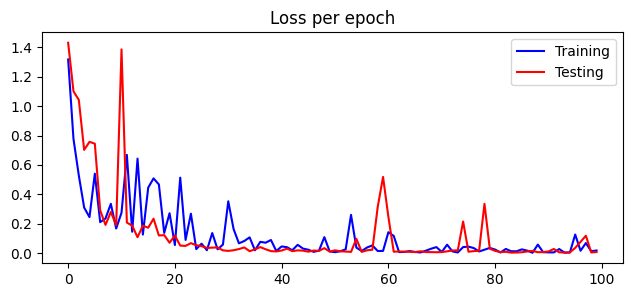

In [41]:
loss_fig, loss_ax = plt.subplots(figsize=(7.5,3))
plt.plot(range(epoch_count), training_loss_list, color="blue")
plt.plot(range(epoch_count), testing_loss_list, color="red")

loss_ax.set_title("Loss per epoch")
loss_ax.legend(["Training", "Testing"])